# Processing coronavirus impact on global flights

### Load Python tools

In [1]:
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import openpyxl
import altair as alt
from altair_saver import save
import lxml
import requests
from shapely.geometry import Point, LineString
import geojson
import json
import glob
import io
import os
import pyarrow
from shapely.geometry import Point, LineString, MultiLineString
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

## FAA airline registristration

In [2]:
planes = pd.read_csv('/Users/mhustiles/data/github/notebooks/aircraft/output/airline_planes.csv')

In [3]:
planes.head()

,name,n_number
0,BENE MARY D,N100
1,STOOS ROBERT A,N10001
2,ENGLISH AIR SERVICE,N10002
3,CAMPBELL CHARLES N,N10003
4,ETOS AIR LLC,N10004


## Process 'flights' metadata

In [4]:
# https://secure.flightradar24.com/general_media/

In [5]:
a_flight = pd.read_csv('coronavirus/20200217_flights.csv')

In [6]:
a_flight.head()

,flight_id,aircraft_id,reg,equip,callsign,flight,schd_from,schd_to,real_to,reserved
0,601952841,7793496,NaN,GRND,R17,NaN,SIN,NaN,NaN,NaN
1,601981055,4648968,NaN,NaN,FLWME2,NaN,SKG,NaN,NaN,NaN
2,601974918,3948014,NaN,NaN,AP01,NaN,CGN,NaN,NaN,NaN
3,601965791,3949334,NaN,GRND,V79,NaN,NaN,NaN,NaN,NaN
4,601965717,1122582,NaN,GRND,RA74006,RA74006,CEK,NaN,NaN,NaN


### Set path for flights and define the files we'll concatenate

In [7]:
path = '/Users/mhustiles/data/data/flights/coronavirus/flights/'
files = glob.glob(os.path.join(path, "*flights.csv"))

### Read the csvs and create a 'date' field in the table

In [8]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(date=os.path.basename(f)) for f in files)

### Combined our newly processed flight files

In [9]:
flights_df_all = pd.concat(file_df, ignore_index=True)

In [10]:
len(flights_df_all)

2149720

### Add owner names from FAA registration

In [11]:
flights_df = flights_df_all.merge(planes, right_on='n_number', left_on='reg', how='left')

In [12]:
flights_df.head()

,flight_id,aircraft_id,reg,equip,callsign,flight,schd_from,schd_to,real_to,reserved,date,name,n_number
0,608291364,4976852,NaN,GRND,FLWME3,NaN,AYT,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
1,608298331,5313483,NaN,NaN,SAATJA4,NaN,TLL,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
2,608288050,4546612,NaN,GRND,RANGER2,NaN,SOF,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
3,608300515,4735585,LJ-Light,GRND,LI,NaN,NaN,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
4,608298634,11402224,NaN,NaN,BIRD,NaN,DMK,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN


### Clean up our dates for use later

In [13]:
flights_df['date'] = flights_df['date']\
    .str.replace('_flights.csv','')

In [14]:
flights_df['date'] = pd.to_datetime(flights_df.date, format='%Y%m%d')
flights_df['month'] = flights_df['date'].dt.month 
flights_df['day'] = flights_df['date'].dt.day 
flights_df['weekday'] = flights_df['date'].dt.weekday_name

### Filter flights list to large, commercial planes?

In [15]:
large_planes = ['B738','A320','A321','B737','A20N',\
                'B739','B77W','B763','A332','B752',\
                'A21N','B789','AT75','A359','B772',\
                'B350','B744','A306', 'B733']

In [16]:
cargo_planes = ['B77L', 'B744', 'B748', 'B762', 'B763', 'B75', 'MD1', 'DC1']

In [17]:
# flights_df = flights_df[~flights_df['equip'].isin(cargo_planes)]

### Remove stray flights by id

In [18]:
strays = ['609551948', '609472464', '609472230', '609483318']

In [19]:
# flights_df = flights_df[~flights_df['equip'].isin(strays)]

### What's left?

In [20]:
len(flights_df)

2149720

In [21]:
global_flights = flights_df.groupby(['date']).agg('size').reset_index(name='flights')

In [22]:
global_flights.head(20)

,date,flights
0,2020-01-07,182377
1,2020-01-14,174493
2,2020-01-21,191671
3,2020-01-28,179810
4,2020-02-03,178703
5,2020-02-10,161538
6,2020-02-17,173752
7,2020-02-24,174097
8,2020-03-03,175658
9,2020-03-10,170359


### Decrease from Jan. 7 to March 31

In [23]:
(((global_flights.iloc[12,1] - global_flights.iloc[0,1])/global_flights.iloc[0,1])*100).round(2)

-59.09

In [24]:
global_flights.to_csv('output/global_flights.csv')

### Filter global flights to just those in the largest airports in Europe and the USA

In [25]:
europe_airports = ['AMS','ARN','ATH','BCN','BRU','BUD','CDG','CPH','DME','DUB','FCO','FRA','GVA','HEL',\
                   'KEF','LGW','LHR','LIS','MAD','MAN','MUC','MXP','ORY','OSL','PRG','SVO',\
                   'VCE','VIE','VKO','WAW','ZRH']

In [26]:
usa_airports = ['ATL','BOS','BWI','CLT','DEN','DFW','DTW','EWR','FLL','IAD','IAH','JFK','LAS','LAX','LGA',\
                'MCO','MIA','MSP','ORD','PHL','PHX','SAN','SEA','SFO','SLC','YUL','YVR','YYZ']

In [27]:
usa_flights_totals = flights_df[flights_df['schd_from'].isin(usa_airports)]
europe_flights_totals = flights_df[flights_df['schd_from'].isin(europe_airports)]

In [28]:
europe_flights_totals_grouped = europe_flights_totals.groupby(['date']).agg('size').reset_index(name='flights')
usa_flights_totals_grouped = usa_flights_totals.groupby(['date']).agg('size').reset_index(name='flights')

In [29]:
flights_us_eu_global = pd.concat([global_flights, europe_flights_totals_grouped['flights'],\
                                  usa_flights_totals_grouped['flights']], axis=1)

In [30]:
flights_us_eu_global.columns = (['date', 'world', 'europe', 'usa'])

In [31]:
flights_us_eu_global['world'] = flights_us_eu_global['world'] - (flights_us_eu_global['europe'] + flights_us_eu_global['usa']) 


In [32]:
flights_us_eu_global.to_csv('output/flights_us_eu_global.csv')

In [33]:
flights_us_eu_global_melt = pd.melt(flights_us_eu_global, id_vars=['date'], \
                                    value_vars=['world', 'europe', 'usa'],
        var_name='location', value_name='flights')

In [34]:
flights_us_eu_global_melt

,date,location,flights
0,2020-01-07,world,145204
1,2020-01-14,world,139024
2,2020-01-21,world,155738
3,2020-01-28,world,143842
4,2020-02-03,world,141813
5,2020-02-10,world,125532
6,2020-02-17,world,137174
7,2020-02-24,world,135868
8,2020-03-03,world,138586
9,2020-03-10,world,134817


In [35]:
all_flights_chart_mobile = alt.Chart(flights_us_eu_global_melt).mark_area(size=4,color='#006D8F').encode(
    x=alt.X('date:T', title='', axis=alt.Axis(grid=False, tickCount=6, format='%m/%d')),
    y=alt.Y('flights:Q', title='', axis=alt.Axis(domainOpacity=0, tickSize=0,grid=True, tickCount=6, format='.0s'),
                             sort=alt.EncodingSortField(
                                field="location",
                                op="sum",
                                order="ascending")),
    color=alt.Color('location:N', legend=None)
).properties(width=300, height=200,
    title='Global flights each Tuesday: Jan. 7 to April 7'
)

all_flights_chart_mobile.configure_view(strokeOpacity=0)

alt.Chart(...)

In [36]:
all_flights_chart_desktop = alt.Chart(flights_us_eu_global_melt).mark_area(size=4,color='#006D8F').encode(
    x=alt.X('date:T', title='', axis=alt.Axis(grid=False, tickCount=6, format='%m/%d')),
    y=alt.Y('flights:Q', title='', axis=alt.Axis(domainOpacity=0, tickSize=0, grid=True, tickCount=6, format='.0s'),
                             sort=alt.EncodingSortField(
                                field="location",
                                op="sum",
                                order="ascending")),
    color=alt.Color('location:N', legend=None)
).properties(width=800, height=400,
    title='Global flights each Tuesday: Jan. 7 to April 7'
)

all_flights_chart_desktop.configure_view(strokeOpacity=0)

alt.Chart(...)

In [37]:
save(all_flights_chart_desktop, 'images/all_flights_chart_desktop.png', scale_factor=2.0)
save(all_flights_chart_mobile, 'images/all_flights_chart_mobile.png', scale_factor=2.0)

In [38]:
save(all_flights_chart_desktop, 'images/all_flights_chart_desktop.svg', scale_factor=2.0)
save(all_flights_chart_mobile, 'images/all_flights_chart_mobile.svg', scale_factor=2.0)

---

### Just flights from CA

In [39]:
socal = ['BUR', 'SNA', 'LGB', 'LAX', 'ONT', 'PSP']
bayarea = ['CCR', 'STS', 'OAK', 'SFO', 'SJC']

In [40]:
cali = ['LAX','SFO','SAN','OAK','SJC','SNA','TIJ','SMF','ONT','BUR','LGB','PSP','FAT','SBA', 'LAS', 'SEA']

In [41]:
ours = pd.DataFrame(flights_df[(flights_df['schd_from'].isin(socal)) | \
                                  (flights_df['schd_from'].isin(bayarea))])

In [42]:
ours.schd_from.value_counts()

LAX    18112
SFO    10858
SJC     3870
SNA     3845
OAK     3752
LGB     2275
ONT     2245
BUR     2222
PSP     1471
STS      678
CCR      625
Name: schd_from, dtype: int64

In [43]:
our_flights = ours.groupby(['date']).agg('size').reset_index(name='flights')

---

### Drop shorter flights without a major airport listed as the final destination

In [44]:
ours = pd.DataFrame(ours.dropna(subset=['real_to']))

In [45]:
ours.schd_from.value_counts()

LAX    13390
SFO     8688
SJC     3659
OAK     3441
SNA     3069
BUR     2030
ONT     1973
LGB     1685
PSP     1315
STS      544
CCR      355
Name: schd_from, dtype: int64

### Make the flight id a string merge later

In [46]:
ours['flight_id'] = ours['flight_id'].astype(str)

In [47]:
ours_slim = ours[['flight_id', 'reg', 'equip', 'flight', 'schd_from', 'real_to', 'name']]

In [48]:
ours_slim

,flight_id,reg,equip,flight,schd_from,real_to,name
70,608290635,9VSGC,A359,SQ37,LAX,SIN,NaN
116,608308449,HL7639,B748,KE214,SFO,ICN,NaN
149,608304259,B18715,B744,CI5137,LAX,TPE,NaN
175,608305412,N26232,B738,UA292,SFO,MCO,UNITED AIRLINES INC
351,608319946,N121DU,BCS1,DL2703,SFO,SEA,DELTA AIR LINES INC
...,...,...,...,...,...,...,...
2149531,599765089,A6EOL,A388,EK226,SFO,DXB,NaN
2149549,599765172,N73299,B738,UA810,SFO,IAH,WELLS FARGO TRUST CO NA TRUSTEE
2149648,599765263,N105DU,BCS1,DL1550,SJC,SEA,DELTA AIR LINES INC
2149653,599765246,N400WN,B737,WN1465,SJC,BUR,SOUTHWEST AIRLINES CO


In [49]:
ours_slim.to_csv('output/ours.csv')

---

## Process 'positions' data showing each point along a flight

In [50]:
a_position = pd.read_csv('/Users/mhustiles/data/data/flights/coronavirus/\
positions/20200217_positions/20200217_602122877.csv')
a_position.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk
0,1581908696,0,295,38.74120,-90.35629,5798,18,0
1,1581908707,0,296,38.74166,-90.35723,5798,0,0
2,1581908716,0,289,38.74215,-90.35832,5798,0,0
3,1581908726,0,300,38.74275,-90.35944,5798,0,0
4,1581908736,0,305,38.74332,-90.36056,5798,24,0


### Set path for our targeted positions directory and define the files we'll concatenate

In [51]:
path = '/Users/mhustiles/data/data/flights/coronavirus/positions/'
files = glob.glob(os.path.join(path, "*/*.csv"), recursive=True)

In [52]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(flightid=os.path.basename(f)) for f in files)

### Concateate the frames

In [53]:
positions_df = pd.concat(file_df, ignore_index=True)

In [54]:
positions_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
0,1586242630,0,99,22.29726,113.91716,22825,0,0,20200407_609507281.csv
1,1586242699,0,39,22.29724,113.91737,2892,0,2000,20200407_609507281.csv
2,1586242785,0,277,22.29727,113.91712,2892,2,2000,20200407_609507281.csv
3,1586242821,0,99,22.29723,113.91735,2892,0,2000,20200407_609507281.csv
4,1586242899,0,234,22.29707,113.91712,2892,0,2000,20200407_609507281.csv


In [55]:
len(positions_df)

48412520

### Combined our newly processed flight positions

In [56]:
positions_df['flightid'] = positions_df['flightid'].str.replace('.csv','')

### Split the flightid field so we have a date string to convert later and also a flightid

In [57]:
positions_df[['datestr','flight_id']] = positions_df.flightid.str.split("_",expand=True,)

In [58]:
len(positions_df)

48412520

In [59]:
positions_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,datestr,flight_id
0,1586242630,0,99,22.29726,113.91716,22825,0,0,20200407_609507281,20200407,609507281
1,1586242699,0,39,22.29724,113.91737,2892,0,2000,20200407_609507281,20200407,609507281
2,1586242785,0,277,22.29727,113.91712,2892,2,2000,20200407_609507281,20200407,609507281
3,1586242821,0,99,22.29723,113.91735,2892,0,2000,20200407_609507281,20200407,609507281
4,1586242899,0,234,22.29707,113.91712,2892,0,2000,20200407_609507281,20200407,609507281


### Merge and filter positions data to flights departing just our four airports

In [60]:
our_positions = ours_slim.merge(positions_df, on='flight_id', how='inner')

In [61]:
len(our_positions)

1136674

---

### Process the 'datestr' field into something we can use

In [62]:
our_positions.head()

,flight_id,reg,equip,flight,schd_from,real_to,name,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,datestr
0,601998047,HL7413,B744,OZ285,SFO,ICN,NaN,1581897680,0,25,37.46589,126.46249,41014,0,3302,20200217_601998047,20200217
1,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899760,36000,224,41.86270,148.38032,2953,387,6207,20200217_602018853,20200217
2,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899794,36000,224,41.81955,148.32317,2953,386,6207,20200217_602018853,20200217
3,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899888,36000,223,41.70224,148.16896,8695,384,2000,20200217_602018853,20200217
4,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899950,36000,224,41.62322,148.06737,8695,382,2000,20200217_602018853,20200217


In [63]:
our_positions['date'] = pd.to_datetime(our_positions.datestr, format='%Y%m%d')

### Convert the unix timestampt to human datetime and localize

In [64]:
our_positions['date_time'] = pd.to_datetime(our_positions['snapshot_id'],unit='s')
our_positions['utc_datetime'] = \
    pd.to_datetime(our_positions['date_time'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('UTC')

In [65]:
our_positions['datetime_pst'] = our_positions['utc_datetime'].dt.tz_convert('America/Los_Angeles')

In [66]:
our_positions['date'] = pd.to_datetime(our_positions['datetime_pst']).dt.strftime('%m/%d/%Y')
our_positions['time'] = pd.to_datetime(our_positions['datetime_pst']).dt.strftime('%H:%M:%S')

In [67]:
positions = pd.DataFrame(our_positions)

In [68]:
positions.sort_values(by='date', ascending=False).head()

,flight_id,reg,equip,flight,schd_from,real_to,name,snapshot_id,altitude,heading,...,radar_id,speed,squawk,flightid,datestr,date,date_time,utc_datetime,datetime_pst,time
1136673,609564894,N412WN,B737,WN1329,SFO,LAX,SOUTHWEST AIRLINES CO,1586303970,0,241,...,2216,0,0,20200407_609564894,20200407,04/07/2020,2020-04-07 23:59:30,2020-04-07 23:59:30+00:00,2020-04-07 16:59:30-07:00,16:59:30
997711,609525622,N993JE,A321,B6224,LAX,JFK,JETBLUE AIRWAYS CORP,1586286587,30625,114,...,591,552,7233,20200407_609525622,20200407,04/07/2020,2020-04-07 19:09:47,2020-04-07 19:09:47+00:00,2020-04-07 12:09:47-07:00,12:09:47
997721,609525622,N993JE,A321,B6224,LAX,JFK,JETBLUE AIRWAYS CORP,1586286995,22975,98,...,3080,470,7233,20200407_609525622,20200407,04/07/2020,2020-04-07 19:16:35,2020-04-07 19:16:35+00:00,2020-04-07 12:16:35-07:00,12:16:35
997720,609525622,N993JE,A321,B6224,LAX,JFK,JETBLUE AIRWAYS CORP,1586286934,23000,98,...,1502,468,7233,20200407_609525622,20200407,04/07/2020,2020-04-07 19:15:34,2020-04-07 19:15:34+00:00,2020-04-07 12:15:34-07:00,12:15:34
997719,609525622,N993JE,A321,B6224,LAX,JFK,JETBLUE AIRWAYS CORP,1586286868,23000,97,...,3080,468,7233,20200407_609525622,20200407,04/07/2020,2020-04-07 19:14:28,2020-04-07 19:14:28+00:00,2020-04-07 12:14:28-07:00,12:14:28


---

## Geography

### Convert to positions to a GeoDataFrame using lon/lat for each point in the flight

In [69]:
positions.loc[1000]

flight_id                       602036559
reg                                B16709
equip                                B77W
flight                                BR7
schd_from                             SFO
real_to                               TPE
name                                  NaN
snapshot_id                    1581937285
altitude                                0
heading                               320
latitude                          25.0779
longitude                         121.238
radar_id                             6586
speed                                  14
squawk                               3226
flightid               20200217_602036559
datestr                          20200217
date                           02/17/2020
date_time             2020-02-17 11:01:25
utc_datetime    2020-02-17 11:01:25+00:00
datetime_pst    2020-02-17 03:01:25-08:00
time                             03:01:25
Name: 1000, dtype: object

In [70]:
positions_geo_all = gpd.GeoDataFrame(
    positions, geometry=gpd.points_from_xy(positions.longitude, positions.latitude))

In [71]:
positions_geo_all_grouped = positions_geo_all.groupby('flight_id')['geometry'].size().reset_index()

In [72]:
postitions_geo_filtered = positions_geo_all_grouped[positions_geo_all_grouped['geometry'] > 10]

In [73]:
postitions_geo_slim = gpd.GeoDataFrame(positions_geo_all.merge(postitions_geo_filtered,\
                                                               on='flight_id', how='inner'))

In [74]:
postitions_geo_slim.rename(columns={"geometry_x": "geometry", "geometry_y": "pointcnt"}, inplace=True)

In [75]:
postitions_geo_slim = postitions_geo_slim.drop(['snapshot_id','latitude', \
                                    'longitude', 'datestr', \
                                   'utc_datetime','squawk',\
                                    'radar_id',\
                                   'heading'], axis=1)

In [76]:
postitions_geo_slim.date.value_counts()

02/17/2020    573947
02/16/2020    278533
04/07/2020    208403
04/06/2020     75394
Name: date, dtype: int64

In [78]:
postitions_geo_slim.to_file('/Users/mhustiles/data/data/flights/\
coronavirus/postitions_geo_slim.geojson', driver='GeoJSON')

### Clip the flight data to around continental United States

In [79]:
!ogr2ogr -f "GeoJSON" '/Users/mhustiles/data/data/flights/coronavirus/positions_geo_clipped.geojson' \
'/Users/mhustiles/data/data/flights/coronavirus/postitions_geo_slim.geojson' \
-clipsrc -136.5 6.4 -62.9 55.7

Warning 1: The output driver does not natively support DateTime type for field date_time. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 1: The output driver does not natively support DateTime type for field datetime_pst. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 1: The output driver does not natively support Time type for field time. Misconversion can happen. -mapFieldType can be used to control field type conversion.


In [80]:
positions_geo_clipped = gpd.read_file('/Users/mhustiles/data/data/flights/\
coronavirus/positions_geo_clipped.geojson')

### Before (Feb. 17) points

In [82]:
positions_geo_before = gpd.GeoDataFrame(positions_geo_clipped[(positions_geo_clipped['date'] == '02/16/2020')|\
(positions_geo_clipped['date'] == '02/17/2020')])

In [83]:
positions_geo_before.to_file('/Users/mhustiles/data/data/flights/coronavirus\
/positions_geo_before.geojson', driver='GeoJSON')

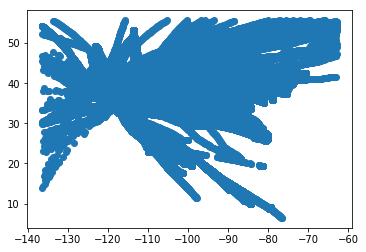

In [84]:
positions_geo_before.plot()

### After (April 7) points

In [85]:
positions_geo_after = gpd.GeoDataFrame(positions_geo_clipped[(positions_geo_clipped['date'] == '04/06/2020')|\
(positions_geo_clipped['date'] == '04/07/2020')])

In [86]:
positions_geo_after.to_file('/Users/mhustiles/data/data/flights/coronavirus\
/positions_geo_after.geojson', driver='GeoJSON')

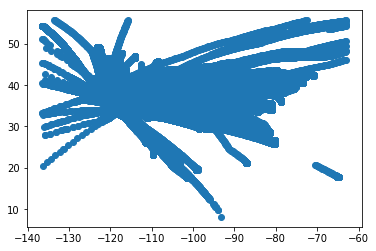

In [87]:
positions_geo_after.plot()

---

### Before lines

In [91]:
positions_geo_before_line = gpd.GeoDataFrame(positions_geo_before.groupby(['flight_id','schd_from','name'])['geometry']\
    .apply(lambda x: LineString(x.tolist())).reset_index())

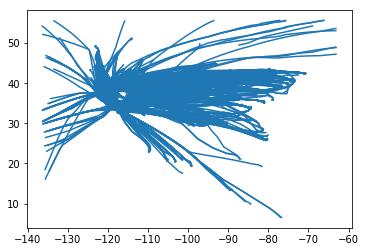

In [92]:
positions_geo_before_line.plot()

### After lines

In [93]:
positions_geo_after_line = gpd.GeoDataFrame(positions_geo_after.groupby(['flight_id','schd_from','name'])['geometry']\
    .apply(lambda x: LineString(x.tolist())).reset_index())

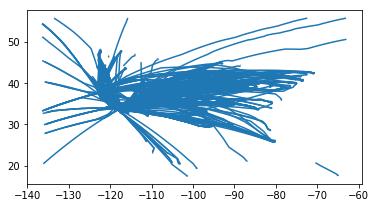

In [94]:
positions_geo_after_line.plot()

### Export before/after lines to geojson

In [95]:
# positions_geo_line.to_file('/Users/mhustiles/data/data/flights/coronavirus\
# /positions_geo_line.geojson', driver='GeoJSON')

In [96]:
positions_geo_before_line.to_file('/Users/mhustiles/data/data/flights/coronavirus\
/positions_geo_before_line.geojson', driver='GeoJSON')

In [ ]:
positions_geo_after_line.to_file('/Users/mhustiles/data/data/flights/coronavirus\
/positions_geo_after_line.geojson', driver='GeoJSON')

### Output to mbtiles for Mapbox

In [98]:
!tippecanoe --generate-ids --force -Z6 -z10 -r1 -pk -pf -o \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line.mbtiles \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line.geojson

For layer 0, using name "positions_geo_after_line"
954 features, 1020152 bytes of geometry, 9206 bytes of separate metadata, 13429 bytes of string pool
  99.9%  10/162/362  


In [ ]:
!tippecanoe --generate-ids --force -Z6 -z10 -r1 -pk -pf -o \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_line.mbtiles \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_line.geojson

---

### What's still flying at LAX?

In [128]:
lax_pos_after = positions_geo_after_line[positions_geo_after_line['schd_from'] == 'LAX']

In [129]:
lax_pos_before = positions_geo_before_line[positions_geo_before_line['schd_from'] == 'LAX']

In [130]:
lax_pos_after_names = lax_pos_after.groupby(['name']).agg('size').reset_index(name='flights')
lax_pos_before_names = lax_pos_before.groupby(['name']).agg('size').reset_index(name='flights')

In [133]:
lax_pos_before_names.sort_values(by='flights', ascending=False).head(10)

,name,flights
10,AMERICAN AIRLINES INC,125
22,DELTA AIR LINES INC,117
50,SKYWEST AIRLINES INC,109
68,WELLS FARGO TRUST CO NA TRUSTEE,108
51,SOUTHWEST AIRLINES CO,95
64,UNITED AIRLINES INC,75
7,ALASKA AIRLINES INC,41
70,WILMINGTON TRUST CO TRUSTEE,26
34,JETBLUE AIRWAYS CORP,24
53,SPIRIT AIRLINES INC,18


In [134]:
lax_pos_after_names.sort_values(by='flights', ascending=False).head(10)

,name,flights
26,SOUTHWEST AIRLINES CO,44
34,WELLS FARGO TRUST CO NA TRUSTEE,37
25,SKYWEST AIRLINES INC,31
12,DELTA AIR LINES INC,30
3,AMERICAN AIRLINES INC,26
32,UNITED AIRLINES INC,25
16,FEDERAL EXPRESS CORP,18
2,ALASKA AIRLINES INC,16
35,WILMINGTON TRUST CO TRUSTEE,13
27,SPIRIT AIRLINES INC,12


In [137]:
lax_pos_before_names.flights.sum()

861

In [136]:
lax_pos_after_names.flights.sum()

316

---

### Cut 'before' GeoJSON files for each of our airports before COVID-19

In [100]:
for airport in positions_geo_before.schd_from.unique():
    positions_geo_before[positions_geo_before['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_before_{}.geojson'.format(airport), driver='GeoJSON')

In [101]:
for airport in positions_geo_before_line.schd_from.unique():
    positions_geo_before_line[positions_geo_before_line['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_before_line_{}.geojson'.format(airport), driver='GeoJSON')

### Cut 'after' GeoJSON files for each of our airports after COVID-19

In [102]:
for airport in positions_geo_after.schd_from.unique():
    positions_geo_after[positions_geo_after['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_after_{}.geojson'.format(airport), driver='GeoJSON')

In [103]:
for airport in positions_geo_after_line.schd_from.unique():
    positions_geo_after_line[positions_geo_after_line['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_after_line_{}.geojson'.format(airport), driver='GeoJSON')

---

### Grid (CA 1 mile)

In [104]:
# grid = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/socal-halfmile.geojson')

In [105]:
# grid.crs = {'init': 'epsg:4326'}
# grid.to_crs({'init': 'epsg:4326'})

In [106]:
# grid.plot()

In [107]:
# df_la = pd.DataFrame()

# for n in la_choppers:
#     c = n['n_number']
#     choppers = positions_geo[positions_geo['reg'] == c]
#     choppers.crs = "epsg:4326"
#     dfsjoin = gpd.sjoin(hexbins,choppers)
#     dfpivot = pd.pivot_table(dfsjoin,index='id',columns='n_number',aggfunc={'n_number':len})
#     dfpivot.columns = dfpivot.columns.droplevel()
#     dfpolynew = hexbins.merge(dfpivot, how='left',on='id')
#     dfpolynew.to_file('/Users/mhustiles/data/data/helicopters/' + c + 'hex.geojson', driver='GeoJSON')

In [108]:
# lax_before = gpd.read_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_LAX.geojson')
# lax_after = gpd.read_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_LAX.geojson')

In [109]:
# positions_geo_before_flying = positions_geo_before[positions_geo_before['speed'] > 10 ]
# positions_geo_after_flying = positions_geo_after[positions_geo_after['speed'] > 10 ]

In [110]:
# positions_geo_before_flying.crs = {'init': 'epsg:4326'}
# positions_geo_before_flying.to_crs({'init': 'epsg:4326'})
# positions_geo_after_flying.crs = {'init': 'epsg:4326'}
# positions_geo_after_flying.to_crs({'init': 'epsg:4326'})

In [111]:
# dfsjoin = gpd.sjoin(positions_geo_after_flying, grid)

In [112]:
# dfsjoingroup = dfsjoin.groupby(['id']).agg('size').reset_index(name='pings')

In [113]:
# dfpolynew = grid.merge(dfsjoingroup, how='left',on='id')

In [114]:
# dfpolynew.to_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.geojson', driver='GeoJSON')

In [115]:
# # !tippecanoe --generate-ids --force -r1 -pk -pf -o \
#     /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.mbtiles \
#     /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.geojson